# MLP-CW3 NN Baseline Training Framework 


## Imports

In [1]:
# set the matplotlib backend so figures can be saved in the background
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib
import keras
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2

import shutil
import fnmatch
import pickle
from keras import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Input
from keras.constraints import max_norm
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
import keras.initializers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras.optimizers
from keras.utils import np_utils
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

/home/as12production/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Environment Settings

In [2]:
#Keras setting
K.set_image_dim_ordering('tf')  #Image dimension ordering

#Random seeds
SEED = 2082018
np.random.seed(SEED)

#Image Settings
IMAGE_RESIZE = (224,224)  # Image size. Process on the by data generator. Should match CNN model input. 
IMAGE_INPUT_SIZE = (224,224,3) #Image Input size to the neural network

#Training Settings
BATCH_SIZE = 32
EPOCH = 10

#Directories
# NOTE: The labels are determined by subfolders. PNG or JPEG images only.
TRAIN_DIR = '../TRAIN' 
VAL_DIR = '../VALID'
TEST_DIR =  '../TEST'

#Model Settting
CLASSIFICATION_MODE = 'binary'  # use 'categorical' for multi-class. 

#Index of the class label represents numerical representation
CLASS_LABELS = ["Benign", "Malignant"]

#Checkpoints and save files

#Saving every epochs that improve val accuracy
#MODEL_CHECKPOINT_FILE="baseline_model-weights-{epoch:02d}-{val_acc:.2f}.hdf5"
# Rewriting save file for epoch that improves val accuracy
MODEL_CHECKPOINT_FILE="inception3-weights.hdf5"  

#Training charts and graphics
MODEL_TRAIN_RESULTS_FILE="inception3_train.pickle"
MODEL_ACCURACY_GRAPH_FILE="inception3_accuracy.pdf"
MODEL_LOSS_GRAPH_FILE="inception3_loss.pdf"
MODEL_EVALUATION_CM_FILE="inception3_CM.pdf"

## Loading Dataset

In [3]:
def buildImageDataset(path, imageResize=None,shuffle=False,seed=0):
    """
    Load dataset into an array. Labels are defined by folder name.
    """
    filenames = []
    data = []
    labels = []
    imagePaths = sorted(list(paths.list_images(path)))
    
    if shuffle == True:
        random.seed(seed)
        random.shuffle(imagePaths)

    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        if imageResize != None:
            image = cv2.resize(image, imageResize)
        image = img_to_array(image)
        data.append(image)
        filenames.append(imagePath)
        label = imagePath.split(os.path.sep)[-2]
        labels.append(CLASS_LABELS.index(label))
    return (np.array(data), np.array(labels), np.array(filenames))

def showClassDistribution(y, labels):
    figure = plt.figure(figsize=(10,5))
    ax = sns.countplot(x = y)
    ax.set_xticklabels(labels)
    plt.show()

In [4]:
X_train, y_train, train_files = buildImageDataset(TRAIN_DIR,imageResize=IMAGE_RESIZE,seed=SEED)
X_valid, y_valid, valid_files = buildImageDataset(VAL_DIR,imageResize=IMAGE_RESIZE,seed=SEED)
X_test, y_test, test_files = buildImageDataset(TEST_DIR,imageResize=IMAGE_RESIZE,seed=SEED)

### Selecting Magnification

In [ ]:
#["-40","-100-","-200-","-400-"]
magnifications = "-400-"

run_this = 0

if run_this == 1:
    index = [i for i,item in enumerate(trainDataFrame["filename"]) if magnifications in item]
    X_train = X_train[index]
    y_train = y_train[index]
    train_files = train_files[index]
    
    index = [i for i,item in enumerate(validDataFrame["filename"]) if magnifications in item]
    X_valid = X_valid[index]
    y_valid = y_valid[index]
    train_files
    index = [i for i,item in enumerate(testDataFrame["filename"]) if magnifications in item]
    X_test = X_test[index]
    y_test = y_test[index]



## Data Exploration

### Training Set 

In [5]:
trainDataFrame = pd.DataFrame({'label':y_train, 'filename':train_files})
print("There are {} items in training set.".format(len(y_train) ))
trainDataFrame.head(10)

There are 5252 items in training set.


,filename,label
0,../TRAIN/Benign/SOB_B_A-14-22549G-100-001.png,0
1,../TRAIN/Benign/SOB_B_A-14-22549G-100-002.png,0
2,../TRAIN/Benign/SOB_B_A-14-22549G-100-003.png,0
3,../TRAIN/Benign/SOB_B_A-14-22549G-100-004.png,0
4,../TRAIN/Benign/SOB_B_A-14-22549G-100-005.png,0
5,../TRAIN/Benign/SOB_B_A-14-22549G-100-006.png,0
6,../TRAIN/Benign/SOB_B_A-14-22549G-100-007.png,0
7,../TRAIN/Benign/SOB_B_A-14-22549G-100-008.png,0
8,../TRAIN/Benign/SOB_B_A-14-22549G-100-009.png,0
9,../TRAIN/Benign/SOB_B_A-14-22549G-100-010.png,0


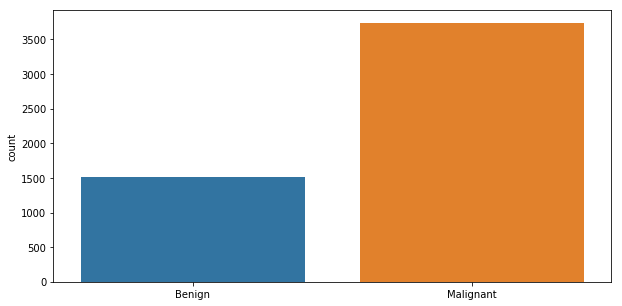

In [6]:
showClassDistribution(y_train, CLASS_LABELS)

### Validation Set

In [7]:
validDataFrame = pd.DataFrame({'label':y_valid, 'filename':valid_files})
print("There are {} items in validation set.".format(len(y_valid) ))
validDataFrame.head(10)

There are 1735 items in validation set.


,filename,label
0,../VALID/Benign/SOB_B_A-14-22549AB-100-001.png,0
1,../VALID/Benign/SOB_B_A-14-22549AB-100-002.png,0
2,../VALID/Benign/SOB_B_A-14-22549AB-100-003.png,0
3,../VALID/Benign/SOB_B_A-14-22549AB-100-004.png,0
4,../VALID/Benign/SOB_B_A-14-22549AB-100-005.png,0
5,../VALID/Benign/SOB_B_A-14-22549AB-100-006.png,0
6,../VALID/Benign/SOB_B_A-14-22549AB-100-007.png,0
7,../VALID/Benign/SOB_B_A-14-22549AB-100-008.png,0
8,../VALID/Benign/SOB_B_A-14-22549AB-100-009.png,0
9,../VALID/Benign/SOB_B_A-14-22549AB-100-010.png,0


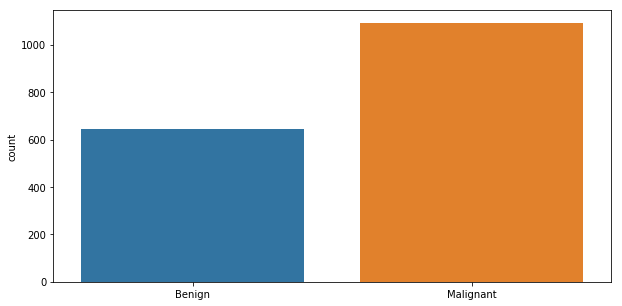

In [8]:
showClassDistribution(y_valid, CLASS_LABELS)

### Test set

In [9]:
testDataFrame = pd.DataFrame({'label':y_test, 'filename':test_files})
print("There are {} items in test set.".format(len(y_test) ))
testDataFrame.head(10)

There are 922 items in test set.


,filename,label
0,../TEST/Benign/SOB_B_A-14-22549CD-100-001.png,0
1,../TEST/Benign/SOB_B_A-14-22549CD-100-002.png,0
2,../TEST/Benign/SOB_B_A-14-22549CD-100-003.png,0
3,../TEST/Benign/SOB_B_A-14-22549CD-100-004.png,0
4,../TEST/Benign/SOB_B_A-14-22549CD-100-005.png,0
5,../TEST/Benign/SOB_B_A-14-22549CD-100-006.png,0
6,../TEST/Benign/SOB_B_A-14-22549CD-100-007.png,0
7,../TEST/Benign/SOB_B_A-14-22549CD-100-008.png,0
8,../TEST/Benign/SOB_B_A-14-22549CD-100-009.png,0
9,../TEST/Benign/SOB_B_A-14-22549CD-100-010.png,0


## Pre-Processing


In [10]:
class ImageStandardizer:
    """
    This class standardizer image to zero mean and unit variance
    Normalization is done for each image channel
    """
    def __init__(self, eps=1e-7):
        self._mean = 0
        self._std = 0
        self._ready = False
        self._epsilon = eps # To prevent divide by zero
    
    def fit(self, train):
        self._mean = np.mean(train,axis=(0, 1, 2, 3))
        self._std = np.std(train, axis=(0, 1, 2, 3))
        self._ready = True
    
    def transform(self, data):
        assert self._ready == True, "ImageStandardizer must be initialized before use. Use fit() to initialize."
        return (data - self._mean)/(self._std + self._epsilon)
    

### Standardization

In [ ]:
run_this = 0

if run_this == 1:
    Standardizer = ImageStandardizer()
    ImageStandardizer.fit(X_train)
    X_train = ImageStandardizer.transform(X_train)
    X_valid = ImageStandardizer.transform(X_valid)

### Data Augmentation

See Keras documentation for details https://faroit.github.io/keras-docs/1.1.0/preprocessing/image/


In [16]:
#No augmentation on baseline. Only normalize to [0,1.0] scale.
trainDataGenerator = ImageDataGenerator(rescale=1./255)
validDataGenerator = ImageDataGenerator(rescale=1./255)
testDataGenerator = ImageDataGenerator(rescale=1./255)
#  data augmentation
#trainDataGenerator = ImageDataGenerator(
#            rescale=1./255,
#            featurewise_center=False,  # set input mean to 0 over the dataset
#            samplewise_center=False,  # set each sample mean to 0
#          featurewise_std_normalization=False,  # divide inputs by std of the dataset
#           samplewise_std_normalization=False,  # divide each input by its std
#           zca_whitening=False,  # apply ZCA whitening
#           rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
#            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#            horizontal_flip=True,  # randomly flip images
#            vertical_flip=False)  # randomly flip images
 #(std, mean, and principal components if ZCA whitening is applied).

trainDataGenerator.fit(X_train)
validDataGenerator.fit(X_valid)
testDataGenerator.fit(X_test)
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test = keras.utils.to_categorical(y_test)


# Building Neural Net Model

In [11]:
# Building Models
def InceptionNet():
    #https://keras.io/applications/#inceptionv3
    #Use Inception 3 without the last layer.
    #Replace last layer with 1 sigmoid for binary classification
    sgd = SGD(lr=0.01, momentum=0.9,nesterov=False)
    model = keras.applications.inception_v3.InceptionV3(include_top=False,
                                                        weights='imagenet',  #Pre-train on ImageNet 
                                                        input_tensor=Input(shape=(224,224,3)),
                                                        input_shape=None,
                                                        pooling='avg',
                                                        classes=2)
    final = Model(input=model.input,output=Dense(2, activation='softmax')(model.output))
    final.summary()
    final.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])    
    return final

model = InceptionNet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


#### Setting checkpoint options

In [12]:
checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#### Loading weights

In case issue with training / crash. Run this to load the weights into model. You can either train the model or use it for classification.


In [13]:
run_this = 0

#Specify checkpoint file here
CHECKPOINT_FILE = MODEL_CHECKPOINT_FILE

###############################################
if run_this == 1:
    model.load_weights(CHECKPOINT_FILE)

In [14]:
X_train /= 255.0
X_valid /= 255.0
X_test /= 255.0

In [17]:
run_this = 1

if run_this == 1:
    #Train models
   
    history = model.fit(x=X_train,y=y_train,
                        validation_data=(X_valid,y_valid),
                        batch_size=32,
                        epochs = 10,
                       callbacks = callbacks_list)
    
    #Saving training result
    with open(MODEL_TRAIN_RESULTS_FILE, "wb") as output_file:
        pickle.dump(history.history, output_file)

Train on 5252 samples, validate on 1735 samples
Epoch 1/10
5252/5252 [==============================] - 134s 26ms/step - loss: 0.2753 - acc: 0.8804 - val_loss: 0.6337 - val_acc: 0.8040

Epoch 00001: val_acc improved from -inf to 0.80403, saving model to inception3-weights.hdf5
Epoch 2/10
5252/5252 [==============================] - 126s 24ms/step - loss: 0.1281 - acc: 0.9507 - val_loss: 0.9815 - val_acc: 0.7499

Epoch 00002: val_acc did not improve
Epoch 3/10
5252/5252 [==============================] - 126s 24ms/step - loss: 0.0928 - acc: 0.9659 - val_loss: 1.1072 - val_acc: 0.7245

Epoch 00003: val_acc did not improve
Epoch 4/10
5252/5252 [==============================] - 126s 24ms/step - loss: 0.0523 - acc: 0.9791 - val_loss: 1.2087 - val_acc: 0.7718

Epoch 00004: val_acc did not improve
Epoch 5/10
5252/5252 [==============================] - 126s 24ms/step - loss: 0.0392 - acc: 0.9863 - val_loss: 1.3813 - val_acc: 0.7890

Epoch 00005: val_acc did not improve
Epoch 6/10
5252/5252 [

# Training

In [15]:
run_this = 1

if run_this == 1:
    #Train models
    history = model.fit_generator(
        trainDataGenerator.flow(X_train, y_train),
        epochs = EPOCH,
        steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
        validation_data=validDataGenerator.flow(X_valid, y_valid),
        callbacks = callbacks_list)
    
    #Saving training result
    with open(MODEL_TRAIN_RESULTS_FILE, "wb") as output_file:
        pickle.dump(history.history, output_file)

Epoch 1/20
164/164 [==============================] - 136s 829ms/step - loss: 0.2638 - acc: 0.8830 - val_loss: 0.6345 - val_acc: 0.7170

Epoch 00001: val_acc improved from -inf to 0.71700, saving model to inception3-weights.hdf5
Epoch 2/20
164/164 [==============================] - 128s 782ms/step - loss: 0.1197 - acc: 0.9548 - val_loss: 1.0561 - val_acc: 0.7948

Epoch 00002: val_acc improved from 0.71700 to 0.79481, saving model to inception3-weights.hdf5
Epoch 3/20
164/164 [==============================] - 128s 783ms/step - loss: 0.0838 - acc: 0.9693 - val_loss: 1.9931 - val_acc: 0.7066

Epoch 00003: val_acc did not improve
Epoch 4/20
164/164 [==============================] - 128s 782ms/step - loss: 0.0890 - acc: 0.9695 - val_loss: 6.6473 - val_acc: 0.4242

Epoch 00004: val_acc did not improve
Epoch 5/20
164/164 [==============================] - 128s 783ms/step - loss: 0.1239 - acc: 0.9585 - val_loss: 1.1552 - val_acc: 0.7648

Epoch 00005: val_acc did not improve
Epoch 6/20
164/16

#### Visualizing Training

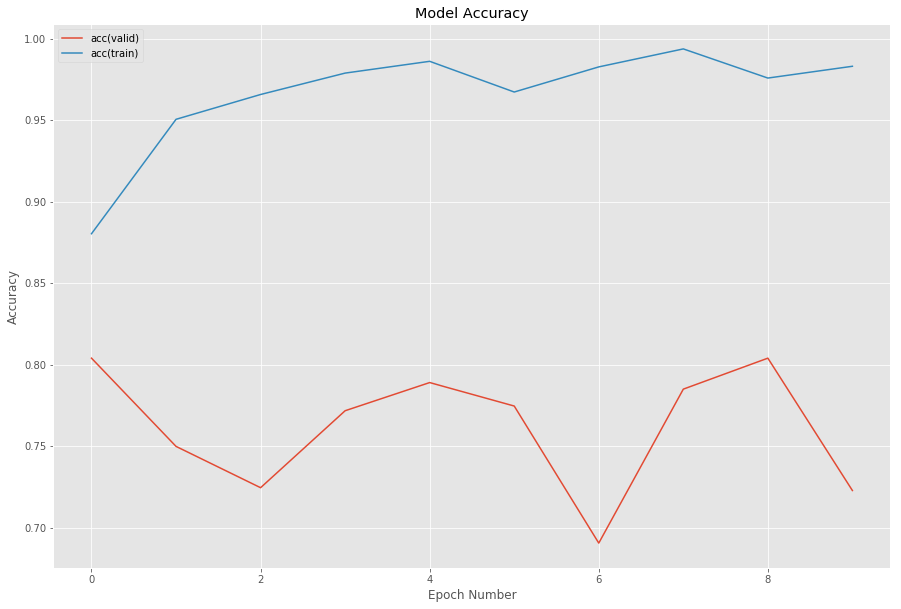

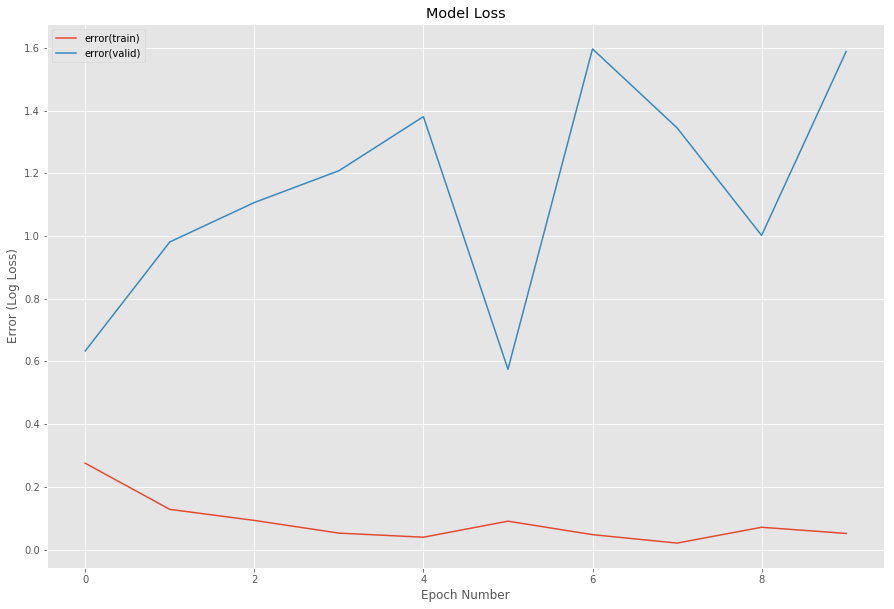

Val Acc:  0.8040345821840962
Train Acc:  0.993907083015994
Val Err:  1.597450022675866
Train Err:  0.2753040386081559


In [18]:
run_this = 1

if run_this == 1:
    with open(MODEL_TRAIN_RESULTS_FILE, "rb") as input_file:
        history = pickle.load(input_file)
    plt.style.use('ggplot')
    accuracy_plot = plt.figure(figsize=(15,10))
    for k in ['val_acc', 'acc']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.legend(['acc(valid)', 'acc(train)'], loc='upper left')
    plt.grid(True)
    plt.show()
    loss_plot = plt.figure(figsize=(15,10))
    for k in ['loss', 'val_loss']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Loss')
    plt.ylabel('Error (Log Loss)')
    plt.xlabel('Epoch Number')
    plt.grid(True)
    plt.legend(['error(train)', 'error(valid)'], loc='upper left')
    plt.show()
    #Save visualization data
    print("Val Acc: ",np.max(np.array(history['val_acc'])))
    print("Train Acc: ", np.max(np.array(history['acc'])))
    print("Val Err: ",np.max(np.array(history['val_loss'])))
    print("Train Err: ", np.max(np.array(history['loss'])))
    accuracy_plot.savefig(MODEL_ACCURACY_GRAPH_FILE, bbox_inches='tight')
    loss_plot.savefig(MODEL_LOSS_GRAPH_FILE, bbox_inches='tight')

# Evaluation

## Validation Set Confusion Matrix

#### Note: 
The labels are hard coded and might not represent the actual label as automatically created by DataGenerator. So switch it around until we figure out the solution

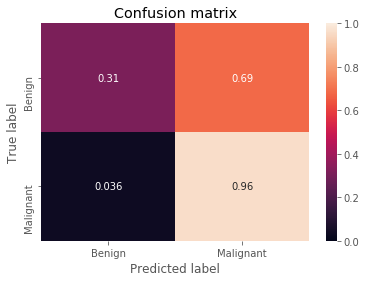

In [19]:
run_this = 1


    
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    plot = plt.figure()
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return plot
    
    
if run_this == 1:
    #model.load_weights(MODEL_CHECKPOINT_FILE)
    y_pred = model.predict(X_valid)
    cm = confusion_matrix(np.argmax(y_valid,axis=1), np.argmax(np.rint(y_pred),axis=1))
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plot = plot_confusion_matrix(cm_norm, classes=CLASS_LABELS)
    plot.savefig(MODEL_EVALUATION_CM_FILE, bbox_inches='tight')

In [30]:
y_pred


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Test Data
Scalar test loss (if the model has no metrics) or list of scalars (if the model computes other metrics). The attribute model.metrics_names will give you the display labels for the scalar outputs.

In [ ]:
run_this = 1

if run_this == 1:
    scores = model.evaluate(X_test,y_test)
    print(scores)
    print(model.metrics_names)
    

In [ ]:
max(y_pred)

In [20]:
run_this = 1
if run_this == 1:
    scores = model.evaluate(X_valid,y_valid)
    print(scores)
    print(model.metrics_names)

1735/1735 [==============================] - 13s 8ms/step
[1.5892770836353893, 0.7227665706567187]
['loss', 'acc']


In [21]:
model2 = InceptionNet()
model2.load_weights(MODEL_CHECKPOINT_FILE)

/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [22]:
if run_this == 1:
    scores = model2.evaluate(X_valid,y_valid)
    print(scores)
    print(model2.metrics_names)

1735/1735 [==============================] - 15s 8ms/step
[1.002343240781702, 0.8040345821840962]
['loss', 'acc']


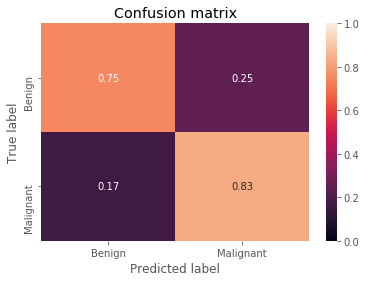

In [23]:
if run_this == 1:
    #model.load_weights(MODEL_CHECKPOINT_FILE)
    y_pred = model2.predict(X_valid)
    cm = confusion_matrix(np.argmax(y_valid,axis=1), np.argmax(np.rint(y_pred),axis=1))
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plot = plot_confusion_matrix(cm_norm, classes=CLASS_LABELS)
    plot.savefig(MODEL_EVALUATION_CM_FILE, bbox_inches='tight')